In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import lightgbm as lgb
import numpy as np
import os

In [2]:
file_path = "../src/wikipedia_edits.csv"
wiki_df = pd.read_csv(file_path)
wiki_df

,title,timestamp,bot_ground_truth,time_interval,signature,comment,edit_size,bloom_filter_classification,formatted_time
0,科紐希 (洛卡奇區),1.731843e+09,False,NaN,28cc4b418940c06b960ce5fa094003f840bb164aa01d26...,更新区划：洛卡奇區 → 沃洛德米爾區,12.0,False,2024-11-17 11:26:06
1,Q130344084,1.731843e+09,False,NaN,122578c2b72da3ed0b3a043ce2124ca8178547b7259d41...,/* wbeditentity-override:0| */ Clearing item t...,-80.0,False,2024-11-17 11:26:07
2,File:Uganda Vs South Africa 19.jpg,1.731843e+09,False,NaN,92103763663469ce560b7ca5077376715e55260d94d68b...,Uploaded own work with UploadWizard,NaN,False,2024-11-17 11:26:06
3,Q130344084,1.731843e+09,False,-1.0,d22948781beb436179296ea006012855fdae08183c3543...,/* wbmergeitems-to:0||Q15439035 */,-2843.0,False,2024-11-17 11:26:06
4,News from Nowhere/Chapter V,1.731843e+09,False,NaN,9d9c4cfe3d99565433cf9120837a3bf75aaaeceadbfa02...,NaN,0.0,False,2024-11-17 11:26:07
...,...,...,...,...,...,...,...,...,...
40002,Category:Media lacking a description,1.731844e+09,True,14.0,c0bfdadb4cc932995c7f768aff20afe191135c8ba5cb3d...,"[[:File:Braunton , North Down Road - geograph....",NaN,True,2024-11-17 11:46:55
40003,Category:Images without source,1.731844e+09,True,14.0,3b050b2fe07fad3e2aec217e94d150e812588b752c4392...,"[[:File:Braunton , North Down Road - geograph....",NaN,True,2024-11-17 11:46:55
40004,Category:Creative Commons Attribution-Share Al...,1.731844e+09,True,14.0,1c84124ef906124d558aebf919de0fdf3515393faf7fd5...,"[[:File:Braunton , North Down Road - geograph....",NaN,True,2024-11-17 11:46:55
40005,Kategoria:Wikiprojekt Lekkoatletyka/hasła,1.731844e+09,True,2.0,554c53459ca5cbc579fc2a716af3f6dfe93989627e37d4...,dodano [[:Dyskusja:Dinesh Fernando]] do kategorii,NaN,True,2024-11-17 11:46:57


In [3]:
def extract_keywords_from_comment(comment):
    """
    Extract keywords or patterns from the edit comment to identify bot-like behavior.
    """
    keywords = ["revert", "undo", "fix", "auto", "bot", "updated", "added"]
    comment_lower = str(comment).lower()
    simplified_comment = ' '.join([word for word in keywords if word in comment_lower])
    return simplified_comment if simplified_comment else 'generic_edit'

# Extract keywords from the comments
wiki_df['comment_keywords'] = wiki_df['comment'].apply(extract_keywords_from_comment)
# Convert comment keywords into features using CountVectorizer
vectorizer = CountVectorizer()
comment_features = vectorizer.fit_transform(wiki_df['comment_keywords']).toarray()
comment_features_df = pd.DataFrame(comment_features, columns=vectorizer.get_feature_names_out())


In [4]:
# Combine numerical features and comment keyword features
wiki_df['edit_size'] = pd.to_numeric(wiki_df['edit_size'], errors='coerce').fillna(0)  # Ensure edit_size is numeric
X = pd.concat([wiki_df[['time_interval', 'edit_size']].reset_index(drop=True), comment_features_df], axis=1)
y = wiki_df['bot_ground_truth'].astype(int)  # Target variable

In [5]:
# Train-test split (90%-10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

artifact_folder = "../../../artifacts/"

def plot_confusion_matrix(conf_matrix, title):
    """
    Plot a confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bot", "Bot"], yticklabels=["Not Bot", "Bot"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.savefig(os.path.join(artifact_folder, title))
    plt.show()

In [39]:
# Sort the dataset by timestamp to ensure no future data is leaked
wiki_df_sorted = wiki_df.sort_values(by="timestamp")

# Define split ratios for 80-10-10
train_ratio = 0.8 # TODO: here 0.9
val_ratio = 0.1

# Calculate split indices
train_index = int(len(wiki_df_sorted) * train_ratio)
val_index = int(len(wiki_df_sorted) * (train_ratio + val_ratio))

# Perform time-based splits
train_data = wiki_df_sorted.iloc[:train_index]  # First 80% for training
val_data = wiki_df_sorted.iloc[train_index:val_index]  # Next 10% for validation
test_data = wiki_df_sorted.iloc[val_index:]  # Remaining 10% for testing

# Ensure 'edit_size' is numeric
train_data['edit_size'] = pd.to_numeric(train_data['edit_size'], errors='coerce').fillna(0)
val_data['edit_size'] = pd.to_numeric(val_data['edit_size'], errors='coerce').fillna(0)
test_data['edit_size'] = pd.to_numeric(test_data['edit_size'], errors='coerce').fillna(0)

# Apply CountVectorizer to each split
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data
train_comment_features = vectorizer.fit_transform(train_data['comment_keywords']).toarray()
val_comment_features = vectorizer.transform(val_data['comment_keywords']).toarray()
test_comment_features = vectorizer.transform(test_data['comment_keywords']).toarray()

# Convert comment features to DataFrames
train_comment_df = pd.DataFrame(train_comment_features, columns=vectorizer.get_feature_names_out())
val_comment_df = pd.DataFrame(val_comment_features, columns=vectorizer.get_feature_names_out())
test_comment_df = pd.DataFrame(test_comment_features, columns=vectorizer.get_feature_names_out())

# Combine numerical and comment features for each split
feature_columns = ['time_interval', 'edit_size']

X_train = pd.concat([train_data[feature_columns].reset_index(drop=True), train_comment_df.reset_index(drop=True)], axis=1)
X_val = pd.concat([val_data[feature_columns].reset_index(drop=True), val_comment_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_data[feature_columns].reset_index(drop=True), test_comment_df.reset_index(drop=True)], axis=1)

# Extract target variable
y_train = train_data['bot_ground_truth'].reset_index(drop=True).astype(int)
y_val = val_data['bot_ground_truth'].reset_index(drop=True).astype(int)
y_test = test_data['bot_ground_truth'].reset_index(drop=True).astype(int)

# Confirm the splits
print("Shapes of splits:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes of splits:
X_train: (32005, 10) y_train: (32005,)
X_val: (4001, 10) y_val: (4001,)
X_test: (4001, 10) y_test: (4001,)


/var/folders/gg/1kd93k4x47q5_gj92ljtjf000000gq/T/ipykernel_30261/3342696910.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['edit_size'] = pd.to_numeric(train_data['edit_size'], errors='coerce').fillna(0)
/var/folders/gg/1kd93k4x47q5_gj92ljtjf000000gq/T/ipykernel_30261/3342696910.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['edit_size'] = pd.to_numeric(val_data['edit_size'], errors='coerce').fillna(0)
/var/folders/gg/1kd93k4x47q5_gj92ljtjf000000gq/T/ipykernel_30261/334269691

[LightGBM] [Info] Number of positive: 12033, number of negative: 19972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 32005, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375973 -> initscore=-0.506678
[LightGBM] [Info] Start training from score -0.506678


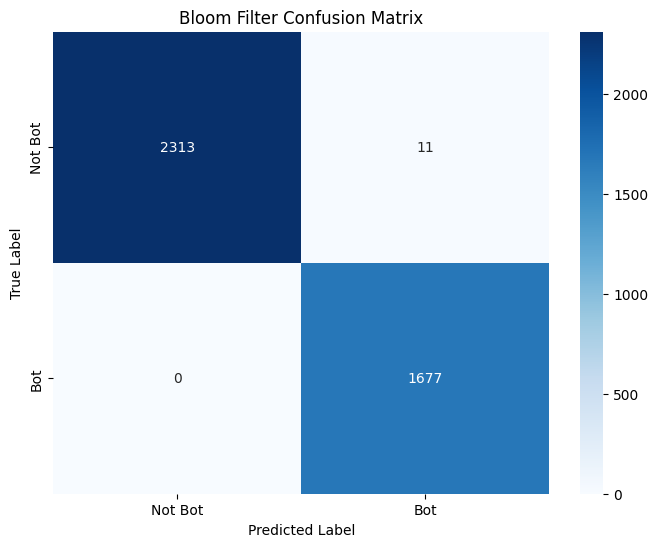

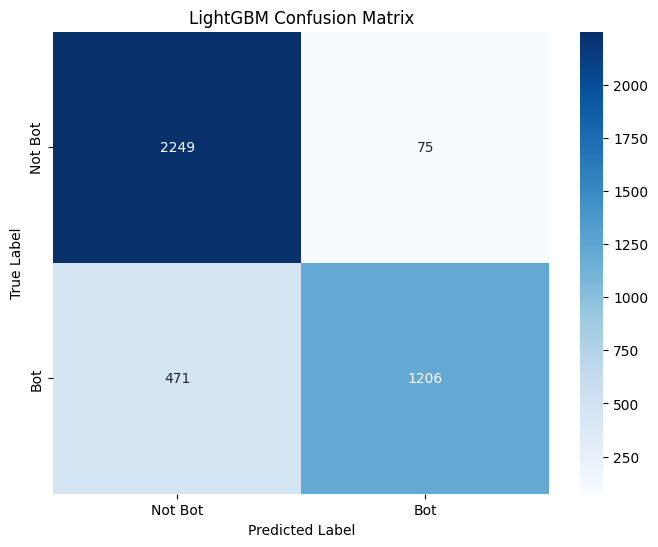

In [40]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate the LightGBM model
ml_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

# Compare with Bloom Filter
bloom_preds = test_data['bloom_filter_classification'].astype(int)  # Extract Bloom Filter predictions for the test set
bloom_metrics = {
    'accuracy': accuracy_score(y_test, bloom_preds),
    'precision': precision_score(y_test, bloom_preds),
    'recall': recall_score(y_test, bloom_preds),
    'f1_score': f1_score(y_test, bloom_preds),
    'confusion_matrix': confusion_matrix(y_test, bloom_preds),
    'false_positives': np.sum((bloom_preds == 1) & (y_test == 0))
}

# Plot confusion matrices for both models
plot_confusion_matrix(bloom_metrics['confusion_matrix'], "Bloom Filter Confusion Matrix")
plot_confusion_matrix(ml_metrics['confusion_matrix'], "LightGBM Confusion Matrix")


In [41]:
# Nicely format metrics
def format_metrics_table(metrics, model_name):
    """
    Format the metrics into a DataFrame for clear display.
    """
    data = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
        model_name: [
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1_score']
        ]
    }
    df = pd.DataFrame(data)
    # 2 digits after comma
    df[model_name] = df[model_name].round(2)
    return df

# Generate DataFrames for ML model and Bloom Filter metrics
ml_metrics_df = format_metrics_table(ml_metrics, "LightGBM")
bloom_metrics_df = format_metrics_table(bloom_metrics, "Bloom Filter")
print("LightGBM")
display(ml_metrics_df)
print("Bloom Filter")
display(bloom_metrics_df)


LightGBM


,Metric,LightGBM
0,Accuracy,0.86
1,Precision,0.94
2,Recall,0.72
3,F1 Score,0.82


Bloom Filter


,Metric,Bloom Filter
0,Accuracy,1.00
1,Precision,0.99
2,Recall,1.00
3,F1 Score,1.00
